<a href="https://colab.research.google.com/github/Jcc329/Jessica_DATA606/blob/main/Notebooks/5.Topic_Modeling_c_v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 606 Capstone
## Notebook 5
## Phase 2 Part 1: Topic Modeling
Jessica Conroy

<b> Goal: </b> 
This Notebook aims to perform topic modeling to identify key topics and differences in those topics among the pre covid and during covid time frames. 
1. LDA and NMF (non-negative matrix factorization) from game description, reviews, tags
2. Text similarity analysis

In [1]:
!pip install gensim==3.8.0

     |████████████████████████████████| 24.2 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
pip install googletrans==3.1.0a0

     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 1.3 MB 31.9 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=c641f99a7feb115efdba74183878daa6876ae1f3433e57d9398867ef49193181
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [3]:
#Import libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import textwrap

import gensim
print(gensim.__version__)
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import preprocess_documents
from io import TextIOWrapper

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# print(stopwords.words('english'))


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from googletrans import Translator

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

3.8.0
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#Load Data
# GameData = pd.read_csv('./FinalSteamData.csv')
GameData = pd.read_csv('./FinalGameData_postProcessing.csv')
# GameData.head()

# Perform some pre-requisite text processing

In [ ]:
#Remove digits from tags. 

def removedigit(s):
    try:
        s = re.sub("\d+", "", s)
    except: 
        s
    return s
GameData['tags.1'] = GameData['tags.1'].apply(removedigit)
GameData['tags.1']

0        action casual arcade shoot em up d colorful st...
1                                                      NaN
2                                                      NaN
3        bullet hell coop shoot em up replay value grea...
4        action shooter action rpg shoot em up rpg gore...
                               ...                        
14947    adventure indie point click puzzle short casua...
14948                                                  NaN
14949                                     adventure casual
14950                                                  NaN
14951                                                  NaN
Name: tags.1, Length: 14952, dtype: object

In [ ]:
#Lemmatize the text (Lemmatisation in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item)
# Topic modeling functions are informed and guided by another project I worked on https://github.com/Jcc329/Text_Summarization/blob/main/notebooks/Topic_Modeling_YunpengLi.ipynb
# used methods for lemmatizing found here https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
def nltk_lemmatize(s):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(str(s))) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence
GameData['tags.1'] = GameData['tags.1'].apply(nltk_lemmatize)
# GameData['tags.1']
GameData['detailed_description.1'] = GameData['detailed_description.1'].apply(nltk_lemmatize)
# GameData['detailed_description.1']
GameData['Top Reviews by Upvotes.1'] = GameData['Top Reviews by Upvotes.1'].apply(nltk_lemmatize)
# GameData['Top Reviews by Upvotes.1']

In [ ]:
#remove additional stopwords
stop_words = set(stopwords.words("english"))
stop_words = stop_words.update(["game",'games', "player", 'play'])

def removestopwords(s):
    #Remove stop words and sent to lowercase
    try:
        s = " ".join([word.lower() for word in str(s).split() if word.lower() not in stop_words])
    except:
        s
    return s

GameData['tags.1'] = GameData['tags.1'].apply(removestopwords)
# GameData['tags.1']
GameData['detailed_description.1'] = GameData['detailed_description.1'].apply(removestopwords)
# GameData['detailed_description.1']
GameData['Top Reviews by Upvotes.1'] = GameData['Top Reviews by Upvotes.1'].apply(removestopwords)
# GameData['Top Reviews by Upvotes.1']

In [ ]:
# Filter out non english text
#https://pypi.org/project/googletrans/
#https://stackoverflow.com/questions/57282711/google-translate-library-is-printing-googletrans-models-translated-at-0x1eaf9bf

def taglanguage(df,col):
    lang_tag = []
    for s in df[col]:
        translator = Translator()
        result = translator.detect(s[0:100])
        lang_tag.append(result.lang)
    # print(lang.detect_language())
    return lang_tag

GameData['tags.Lang'] = taglanguage(GameData, 'tags.1')
# GameData['tags.1']
GameData['detailed_description.Lang'] =  taglanguage(GameData, 'detailed_description.1')
# GameData['detailed_description.1']
GameData['Top Reviews by Upvotes.Lang'] =  taglanguage(GameData, 'Top Reviews by Upvotes.1')
# GameData['detailed_description.Lang']
GameData.to_csv('./FinalGameData_postProcessing.csv')


KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
files.download('FinalGameData_postProcessing.csv')

In [ ]:
GameData[GameData['detailed_description.Lang']!='en']
GameData[GameData['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
#Nans were interpretted as [ht, zh-CN]	

# Functions for preparing the text data for the LDA/NMF model application and doing coherence testing

In [5]:
#Split text into corpuses showing array of values
#Create Pre and During Covid data sets to use later:

GameData = GameData.fillna('')
preCOVID = GameData[GameData['Release Year'].isin([2018,2019])]
COVID = GameData[GameData['Release Year'].isin([2021,2022])]
GameData['Top Reviews by Upvotes.1'] = GameData['Top Reviews by Upvotes.1'].str.replace('game', '') #somehow I'm still getting GAME in my all my review results so retrying with this removed

GameData = GameData.fillna('')
# All Data
Descriptions_all = GameData[GameData['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
Reviews_all = GameData[GameData['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes.1'].values
Tags_all = GameData[GameData['tags.Lang'].astype(str).str.contains('en')]['tags.1'].values

# preCOVID Data
Descriptions_preCOVID = preCOVID[preCOVID['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
Reviews_preCOVID = preCOVID[preCOVID['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes.1'].values
Tags_preCOVID = preCOVID[preCOVID['tags.Lang'].astype(str).str.contains('en')]['tags.1'].values

# duringCOVID Data
Descriptions_COVID = COVID[COVID['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
Reviews_COVID = COVID[COVID['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes.1'].values
Tags_COVID = COVID[COVID['tags.Lang'].astype(str).str.contains('en')]['tags.1'].values

In [6]:
# Function to create dictionary, bag of words, and tokenized text: https://github.com/Jcc329/Text_Summarization/blob/main/notebooks/Topic_Modeling_YunpengLi.ipynb
# https://radimrehurek.com/gensim/parsing/preprocessing.html
def build_dictionary_preprocess_corpus(text_corpus):
  
  # Preprocess documents 
  tokenized_texts = preprocess_documents(text_corpus)
  
  # Create a dictionary
  dictionary = Dictionary(tokenized_texts)
  
  # Create a list of lists of bow for documents
  bow_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

  return dictionary, bow_corpus, tokenized_texts

In [7]:
#Function for calculating coherence score: https://github.com/Jcc329/Text_Summarization/blob/main/notebooks/Topic_Modeling_YunpengLi.ipynb
# coherence_type can be 'u_mass' or 'c_v'
# algorithm can be 'LSI' or 'LDA'
def compute_coherence_score(tokenized_texts, bow_corpus, dictionary, num_topics, coherence_type, algorithm):
  if algorithm == 'LSI':
    model = LsiModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary, passes = 2)

  coherence = CoherenceModel(model=model,
                              corpus=bow_corpus,
                              texts=tokenized_texts,
                              dictionary=dictionary,
                              coherence=coherence_type)
  return coherence.get_coherence()

In [8]:
def generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm, coherence_type='c_v'):
  
  coherence_scores=[]
  min_score=0
  max_score=0

  best_num_topics=1

  for k in range(min_topics, max_topics):
    score = compute_coherence_score(tokenized_texts, bow_corpus, dictionary, k, coherence_type, algorithm)
    coherence_scores.append(score)

    if coherence_type == 'u_mass':
      if score < min_score :
        min_score = score
        best_num_topics = k
    else: # coherence_type == 'c_v'
      if score > max_score:
        max_score = score
        best_num_topics= k


  return coherence_scores, best_num_topics

In [9]:
#function for plotting coherence score
import matplotlib.pyplot as plt
import matplotlib.style as style
#%matplotlib inline

def plot_coherence_scores(min_topics, max_topics, coherence_scores, coherence_type, algorithm, legend=''):
  style.use('fivethirtyeight')

  x = [int(i) for i in range(min_topics, max_topics)]

  plt.figure(figsize=(10,8))
  plt.plot(x, coherence_scores)
  plt.xlabel('Number of topics')
  plt.ylabel('Coherence Value')
  plt.title(legend + ' ' + algorithm + ' Coherence Scores by number of Topics (' + coherence_type + ')')

In [10]:
#Function to print topics
def print_topics(dictionary, bow_corpus, num_topics, algorithm, num_words=10, friendly_print=True):
  
  if algorithm == 'LSI':
    model = LsiModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2)

  if friendly_print:
    # Extract terms from results returned by show_topic()
    for topic_number in range(0, num_topics):
      terms = []
      for term, wt in model.show_topic(topic_number, num_words):
        terms.append(term)
    
      print('Topic ' + str(topic_number) + ':', terms)

  else:
    topics = model.print_topics(num_topics, num_words)
    for topic in topics:
      print(topic)

  return model

## Functions for NMF Modeling

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

In [12]:
def print_NMF_topics(tokenized_texts, max_df=0.95, min_df=1, number_topics=20, number_words_per_topic=10):
  
  text_list=[]

  for token_array in tokenized_texts:
    text_list.append(" ".join(token_array))  # concat tokens for each document to make compatible format for vectorizer.fit_transform()

  vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
  X = vectorizer.fit_transform(text_list)

  idx_to_word = np.array(vectorizer.get_feature_names())

  # apply NMF
  nmf = NMF(n_components=number_topics, solver="mu")
  W = nmf.fit_transform(X)  # document_topics
  H = nmf.components_       # topic_terms

  for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word [topic.argsort()[-number_words_per_topic:]]])))

#Run the models

#All Data

## Descriptions

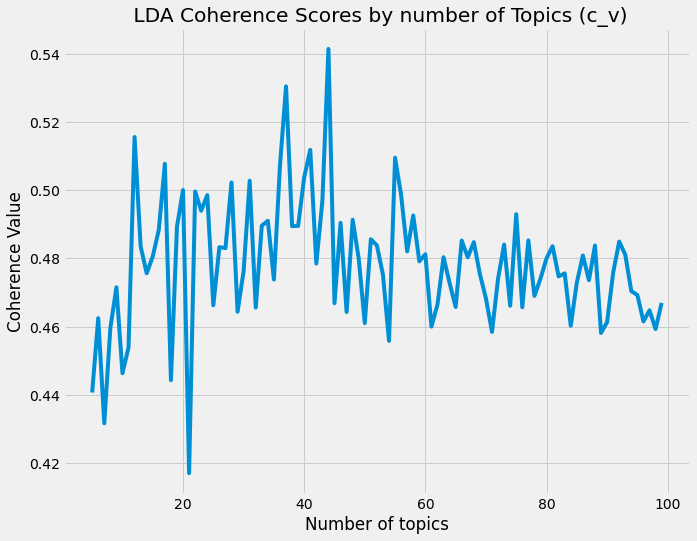

In [13]:
#We are using u_mass over c_v to calculate coherence because u_mass measures relationships with preceding and subsequent words and tends to perform better when compared with other coherence metrics (https://github.com/dice-group/Palmetto/issues/12)
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Descriptions_all)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [14]:
print('The best number of Description topics found by c_v coherence score:', best_num_topics_cv_lda)

The best number of Description topics found by u-mass coherence score: 44


In [15]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['file', 'soundtrack', 'folder', 'game', 'origin', 'dlc', 'digit', 'steam', 'spider', 'includ', 'local', 'directori', 'format', 'rebel', 'instal']
Topic 1: ['word', 'novel', 'voic', 'woman', 'visual', 'sister', 'school', 'love', 'act', 'document', 'romanc', 'student', 'visitor', 'stori', 'episod']
Topic 2: ['tile', 'angel', 'artbook', 'golf', 'vampir', 'quotmo', 'sketch', 'mahjong', 'enjoi', 'illustr', 'jupit', 'suzuki', 'want', 'special', 'kawaiiquot']
Topic 3: ['pack', 'glass', 'freestyl', 'prime', 'sanctuari', 'exclus', 'epic', 'anniversari', 'bicycl', 'homeland', 'offspr', 'rewind', 'hollow', 'horizon', 'vii']
Topic 4: ['gangster', 'tenni', 'pipe', 'brian', 'bank', 'target', 'convert', 'spot', 'clown', 'round', 'voxel', 'ben', 'file', 'clearanc', 'maria']
Topic 5: ['airport', 'labyrinth', 'intern', 'plugin', 'sticker', 'pearl', 'termin', 'runwai', 'veloc', 'joe', 'snowman', 'hub', 'chocol', 'taxiwai', 'wing']
Topic 6: ['mega', 'titan', 'synth', 'circl', 'saya', 'ralli', 'p

In [ ]:
print_NMF_topics(tokenized_texts)

## Reviews

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Reviews_all)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [18]:
print('The best number of Review topics found by C_V coherence score:', best_num_topics_cv_lda)

The best number of Review topics found by C_V coherence score: 25


In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

In [ ]:
print_NMF_topics(tokenized_texts)

## Tags

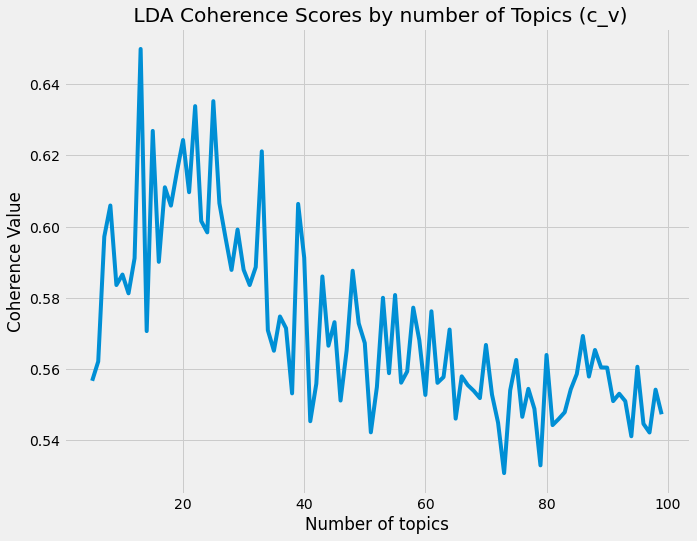

In [21]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Tags_all)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_cv_lda)

In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

In [ ]:
print_NMF_topics(tokenized_texts)

#Pre-Covid
## Descriptions

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Descriptions_preCOVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [26]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_cv_lda)

The best number of Review topics found by u-mass coherence score: 60


In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

In [ ]:
print_NMF_topics(tokenized_texts)

## Reviews

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Reviews_preCOVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_cv_lda)

In [31]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['game', 'like', 'plai', 'train', 'fun', 'time', 'good', 'level', 'want', 'achiev', 'us', 'bui', 'build', 'know', 'recommend']
Topic 1: ['volum', 'troll', 'vikar', 'tagora', 'rout', 'like', 'good', 'charact', 'driver', 'game', 'alternia', 'write', 'think', 'time', 'love']
Topic 2: ['game', 'harass', 'like', 'liar', 'plai', 'us', 'lei', 'charact', 'vile', 'review', 'forum', 'thing', 'time', 'thread', 'nice']
Topic 3: ['game', 'stori', 'like', 'feel', 'good', 'fun', 'think', 'plai', 'charact', 'ski', 'end', 'bui', 'investig', 'soh', 'plot']
Topic 4: ['ship', 'game', 'jump', 'dlc', 'fleet', 'like', 'mode', 'cylon', 'mission', 'new', 'anabasi', 'time', 'great', 'fun', 'good']
Topic 5: ['train', 'engin', 'locomot', 'scenario', 'sound', 'drive', 'dlc', 'model', 'car', 'brake', 'cab', 'rout', 'unit', 'dtm', 'loco']
Topic 6: ['game', 'plai', 'like', 'dinosaur', 'pretti', 'good', 'boobi', 'herbivor', 'squirrel', 'awesom', 'dude', 'scam', 'man', 'boi', 'time']
Topic 7: ['song', 'rout', 

In [ ]:
print_NMF_topics(tokenized_texts)

## Tags

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Tags_preCOVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by c_v coherence score:', best_num_topics_cv_lda)

In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

In [36]:
print_NMF_topics(tokenized_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 1: tank,nuditi,music,educ,simul,arcad,action,adventur,casual,indi
Topic 2: actionadventur,beat,roguelit,shoot,slash,hack,roguelik,difficult,adventur,action
Topic 3: surviv,singleplay,train,realist,strategi,walk,sim,manag,action,simul
Topic 4: puzzleplatform,fmv,explor,click,point,rpg,rpgmaker,choos,textbas,adventur
Topic 5: singleplay,horror,puzzleplatform,difficult,card,clicker,multiplay,massiv,plai,free
Topic 6: histor,board,space,manag,rt,tower,defens,action,indi,strategi
Topic 7: atmospher,funni,retro,graphic,pixel,difficult,great,soundtrack,singleplay,platform
Topic 8: indi,craft,sandbox,world,open,roguelik,fp,rpg,earli,access
Topic 9: slash,roguelit,partybas,fantasi,roguelik,jrpg,textbas,anim,rpgmaker,rpg
Topic 10: dinosaur,dark,surviv,zombi,fp,nuditi,horror,indi,gore,violent
Topic 11: golf,arcad,drive,motorbik,basketbal,footbal,automobil,indi,race,sport
Topic 12: violent,time,board,multiplay,sport,card,game,action,adventur,casual
Topic 13: nsfw,meme,protagonist,femal,henta

# Covid Data
## Description

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Descriptions_COVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by u-mass coherence score:', best_num_topics_cv_lda)

In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

In [ ]:
print_NMF_topics(tokenized_texts)

## Reviews

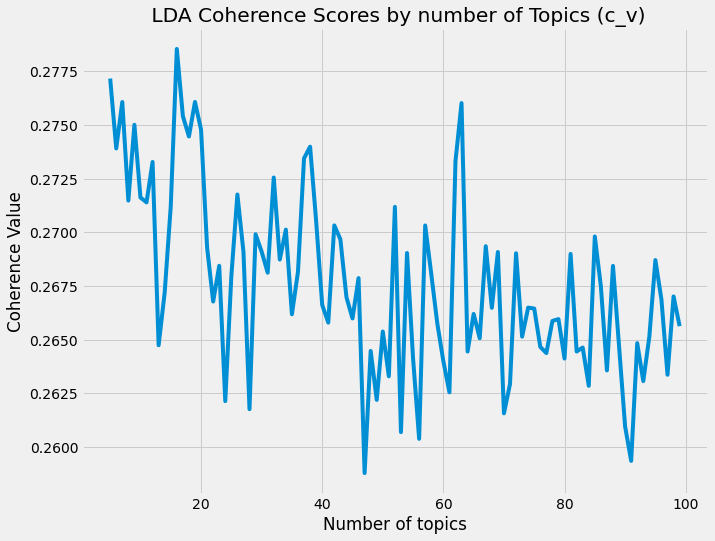

In [41]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Reviews_COVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by c_v coherence score:', best_num_topics_cv_lda)

In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

In [ ]:
print_NMF_topics(tokenized_texts)

## Tags

In [ ]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(Tags_COVID)
min_topics, max_topics = 5, 100
coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
plot_coherence_scores(min_topics, max_topics, coherence_scores_cv_lda, coherence_type='c_v', algorithm='LDA')

In [ ]:
print('The best number of Review topics found by c_v coherence score:', best_num_topics_cv_lda)

In [ ]:
lda_model = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)

In [ ]:
print_NMF_topics(tokenized_texts)

In [49]:
## LDAvis 

In [ ]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 5.0 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=7c77ab95823c2140dd0582c740cc08df980d771e411eb9b64ccbdc6726522e83
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [ ]:
import pyLDAvis.gensim

# Visualize the topics
pyLDAvis.enable_notebook()

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22     0.070628  0.051118       1        1  7.700339
25    -0.011724  0.127387       2        1  7.545711
17     0.033865  0.080003       3        1  6.792284
23    -0.067534  0.124176       4        1  5.937983
11     0.034607 -0.140430       5        1  5.474947
4     -0.017784 -0.067076       6        1  4.560551
7      0.087355  0.054115       7        1  4.428697
28    -0.118902 -0.035072       8        1  4.330380
14     0.110493 -0.024239       9        1  4.317067
19     0.105186 -0.014051      10        1  4.304318
30     0.084075 -0.051719      11        1  3.492749
16    -0.073244  0.000973      12        1  3.234403
10     0.020853 -0.070616      13        1  3.159596
32    -0.026916  0.064288      14        1  3.001455
5     -0.002472  0.060710      15        1  2.928275
9     -0.075495 -0.091472      16        1  2.423413
24    -0.086893  0.108403      17        1  2.377363
3     -0.021720 -0.079432      18        1  2.369291
21     0.033462 -0.115729      19        1  2.312114
31     0.030041  0.019199      20        1  2.237531
12     0.054282  0.017520      21        1  2.016922
8     -0.005008  0.021122      22        1  1.822431
1     -0.068069  0.052327      23        1  1.783105
2      0.052725 -0.077303      24        1  1.650724
27     0.096113  0.016436      25        1  1.545592
20     0.001844  0.035412      26        1  1.435692
26     0.014915 -0.012176      27        1  1.292608
15     0.034302 -0.025009      28        1  1.248458
18     0.023392  0.016288      29        1  1.156938
13    -0.013207  0.025098      30        1  1.034934
6     -0.041348 -0.000265      31        1  1.017607
0     -0.002250  0.010194      32        1  0.553391
29    -0.255570 -0.080181      33        1  0.513130, topic_info=          Term        Freq       Total Category  logprob  loglift
160   platform  688.000000  688.000000  Default  30.0000  30.0000
48     shooter  509.000000  509.000000  Default  29.0000  29.0000
76      horror  339.000000  339.000000  Default  28.0000  28.0000
119  multiplay  348.000000  348.000000  Default  27.0000  27.0000
5       casual  799.000000  799.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
72    adventur    3.606979  793.662143  Topic33  -3.8682  -0.1214
8         indi    3.757299  915.159371  Topic33  -3.8274  -0.2230
123       cute    2.395629  359.377823  Topic33  -4.2774   0.2617
19   atmospher    2.395626  379.298006  Topic33  -4.2774   0.2077
126       game    2.182564  220.359854  Topic33  -4.3706   0.6576

[1899 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
55        1  0.032410  abstract
55        3  0.097231  abstract
55        4  0.226871  abstract
55        5  0.016205  abstract
55        7  0.048615  abstract
...     ...       ...       ...
87       22  0.011919     zombi
87       24  0.071513     zombi
87       25  0.047675     zombi
87       29  0.011919     zombi
87       30  0.011919     zombi

[5911 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 26, 18, 24, 12, 5, 8, 29, 15, 20, 31, 17, 11, 33, 6, 10, 25, 4, 22, 32, 13, 9, 2, 3, 28, 21, 27, 16, 19, 14, 7, 1, 30])

# See Notebook 5.2 for text similarity analysis